In [1]:
import os
import time
import copy
import torch
import joblib
import numpy as np
import pandas as pd
import seaborn as sb
import networkx as nx
from tqdm.notebook import tqdm
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
from xgboost import XGBRegressor as XGBR
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.model_selection import cross_validate, StratifiedKFold

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
pd.set_option("display.max_columns", 100)

In [2]:
def plot_corr_df(corr_df, file_name=None, show=True):
    """
    corr_df must be a pandas.DataFrame().corr() object
    Automatically adjusts the plot size based on the number of variables, ensuring all squares in the heatmap are evenly sized.
    """
    import numpy as np
    import pandas as pd
    import plotly.graph_objects as go
    import plotly.figure_factory as ff
    from scipy.cluster.hierarchy import linkage

    labels = corr_df.columns
    n_vars = len(labels)

    # Define square size and compute overall figure dimensions
    square_size = 30  # Size of each heatmap cell in pixels
    heatmap_size = square_size * n_vars  # Total size for heatmap portion
    dendro_size = 200  # Fixed size for dendrogram (can be adjusted)

    # Total figure dimensions
    fig_width = min(1000, heatmap_size + dendro_size + 200)  # 200 for margins and color bar
    fig_height = min(950, heatmap_size + dendro_size + 150)  # 150 for margins and labels

    # Initialize figure by creating upper dendrogram
    fig = ff.create_dendrogram(
        corr_df.values, 
        labels=labels,
        orientation='bottom', 
        linkagefun=lambda x: linkage(
            x, method="ward", optimal_ordering=True
        )
    )
    for i in range(len(fig['data'])):
        fig['data'][i]['yaxis'] = 'y2'

    # Create Side Dendrogram
    dendro_side = ff.create_dendrogram(
        corr_df.values, 
        labels=labels,
        orientation='right',
        linkagefun=lambda x: linkage(
            x, method="ward", optimal_ordering=True
        )
    )
    for i in range(len(dendro_side['data'])):
        dendro_side['data'][i]['xaxis'] = 'x2'

    # Add Side Dendrogram Data to Figure
    for data in dendro_side['data']:
        fig.add_trace(data)

    # Create Heatmap
    dendro_leaves = dendro_side['layout']['yaxis']['ticktext']

    heatmap = [
        go.Heatmap(
            x=dendro_leaves,
            y=dendro_leaves,
            z=corr_df.loc[dendro_leaves, dendro_leaves],
            colorscale='tempo',
            zmin=-1,
            zmax=1
        )
    ]

    heatmap[0]['x'] = fig['layout']['xaxis']['tickvals']
    heatmap[0]['y'] = fig['layout']['xaxis']['tickvals']

    # Add Heatmap Data to Figure
    for data in heatmap:
        fig.add_trace(data)

    # Adjust layout to dynamically resize based on the number of variables
    fig.update_layout(
        autosize=False,
        width=fig_width,
        height=fig_height,
        showlegend=False,
        hovermode='closest',
        margin=dict(l=15, r=15, t=15, b=15),  # Adjust margins dynamically
    )

    # Edit xaxis (bottom dendrogram)
    fig.update_layout(xaxis={
        'domain': [.15, 1],  # Dynamically adjust domain based on space
        'mirror': False,
        'showgrid': False,
        'showline': False,
        'zeroline': False,
        'ticktext': dendro_leaves,
        'ticks': "",
    })
    # Edit xaxis2 (side dendrogram axis)
    fig.update_layout(xaxis2={
        'domain': [0, .15],  # Adjust domain for side dendrogram
        'mirror': False,
        'showgrid': False,
        'showline': False,
        'zeroline': False,
        'showticklabels': False,
        'ticks': ""
    })
    
    # Edit yaxis (heatmap and side dendrogram)
    fig.update_layout(yaxis={
        'domain': [0, .85],  # Dynamically adjust domain based on space
        'mirror': False,
        'showgrid': False,
        'showline': False,
        'zeroline': False,
        'showticklabels': False,
        'ticks': "",
        'ticktext': dendro_leaves,
        'tickvals': np.array(range(n_vars)) * 10 + 5
    })
    # Edit yaxis2 (top dendrogram axis)
    fig.update_layout(yaxis2={
        'domain': [.85, 1],  # Adjust domain for top dendrogram
        'mirror': False,
        'showgrid': False,
        'showline': False,
        'zeroline': False,
        'showticklabels': False,
        'ticks': ""
    })

    if file_name:
        fig.write_html(file_name)
    
    # Plot!
    if show:
        fig.show()


In [3]:
def get_low_corr_columns(corr_df, corr_th=.7):
    mezo_corr = corr_df.abs()
    while (mezo_corr >= corr_th).sum().sum() > len(mezo_corr):
        columns_over_corr_counts = (mezo_corr >= corr_th).sum()
        if columns_over_corr_counts.sum() > len(mezo_corr):
            col_to_remove = mezo_corr.columns[
                columns_over_corr_counts.argmax()
            ]
            mezo_corr = mezo_corr.drop(columns=col_to_remove).drop(index=col_to_remove)

    low_corr_columns = np.array(mezo_corr.columns)
    
    return low_corr_columns

,learning_rate,n_estimators,max_depth,col_sample,corr_th,n_quantiles,RMSE_avg,RMSE_std,time_s,rank_1_feature,rank_1_importance,rank_2_feature,rank_2_importance,rank_3_feature,rank_3_importance,rank_4_feature,rank_4_importance,rank_5_feature,rank_5_importance,rank_6_feature,rank_6_importance,rank_7_feature,rank_7_importance,rank_8_feature,rank_8_importance,rank_9_feature,rank_9_importance,rank_10_feature,rank_10_importance,rank_11_feature,rank_11_importance,rank_12_feature,rank_12_importance,rank_13_feature,rank_13_importance,rank_14_feature,rank_14_importance,rank_15_feature,rank_15_importance,rank_16_feature,rank_16_importance,rank_17_feature,rank_17_importance,rank_18_feature,rank_18_importance,rank_19_feature,rank_19_importance,rank_20_feature,rank_20_importance


  0%|          | 0/200 [00:00<?, ?it/s]

learning_rate=0.4, n_estimators=810, max_depth=17, col_sample=0.95, corr_th=0.85, n_quantiles=5: 0it [00:00, ?…

Average RMSE: 3382.63
Standard Deviation: 28.93


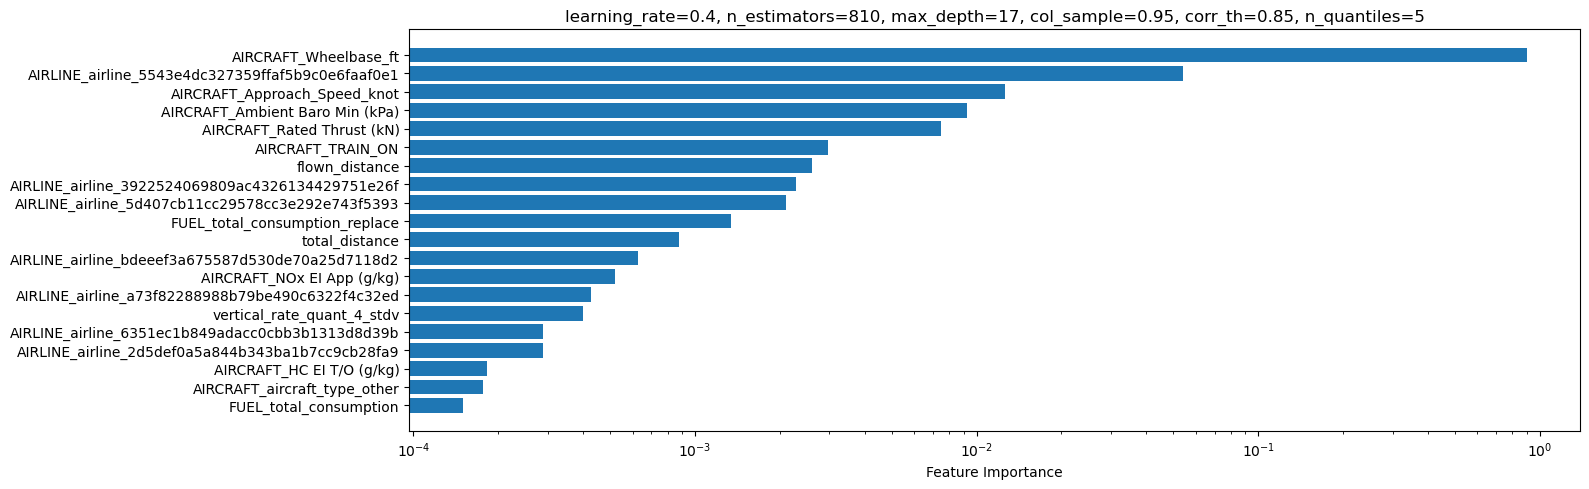

learning_rate=0.07, n_estimators=920, max_depth=9, col_sample=0.9, corr_th=0.9, n_quantiles=5: 0it [00:00, ?it…

Average RMSE: 2759.86
Standard Deviation: 17.84


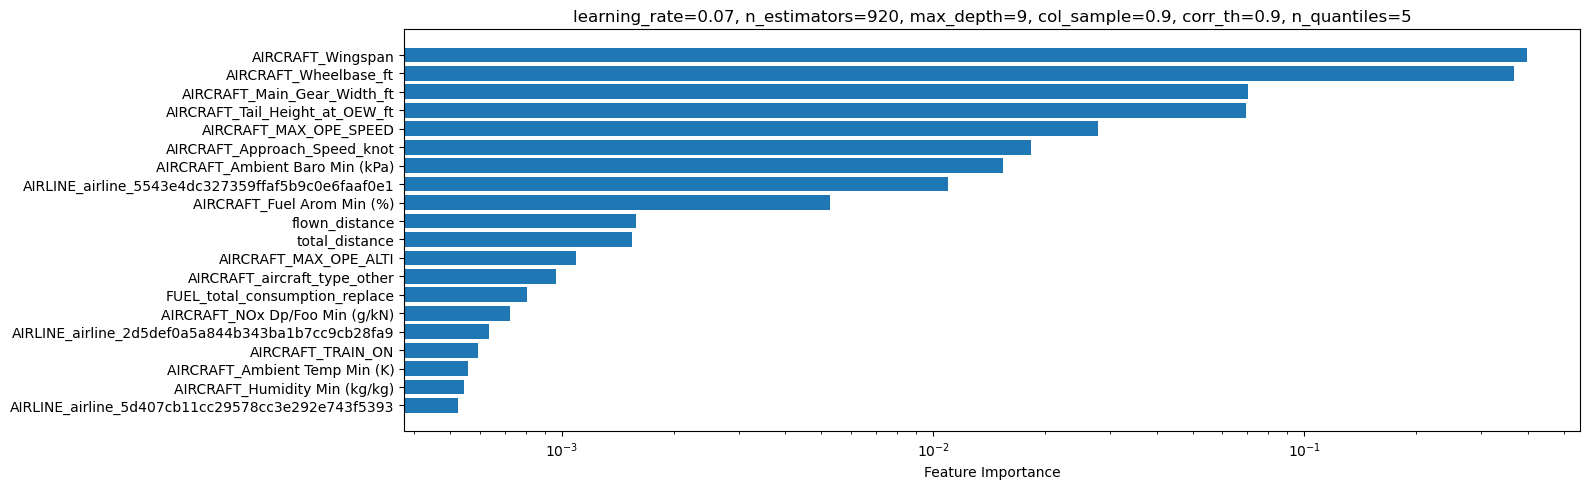

learning_rate=0.03, n_estimators=330, max_depth=13, col_sample=0.8, corr_th=0.8, n_quantiles=5: 0it [00:00, ?i…

Average RMSE: 2834.54
Standard Deviation: 18.99


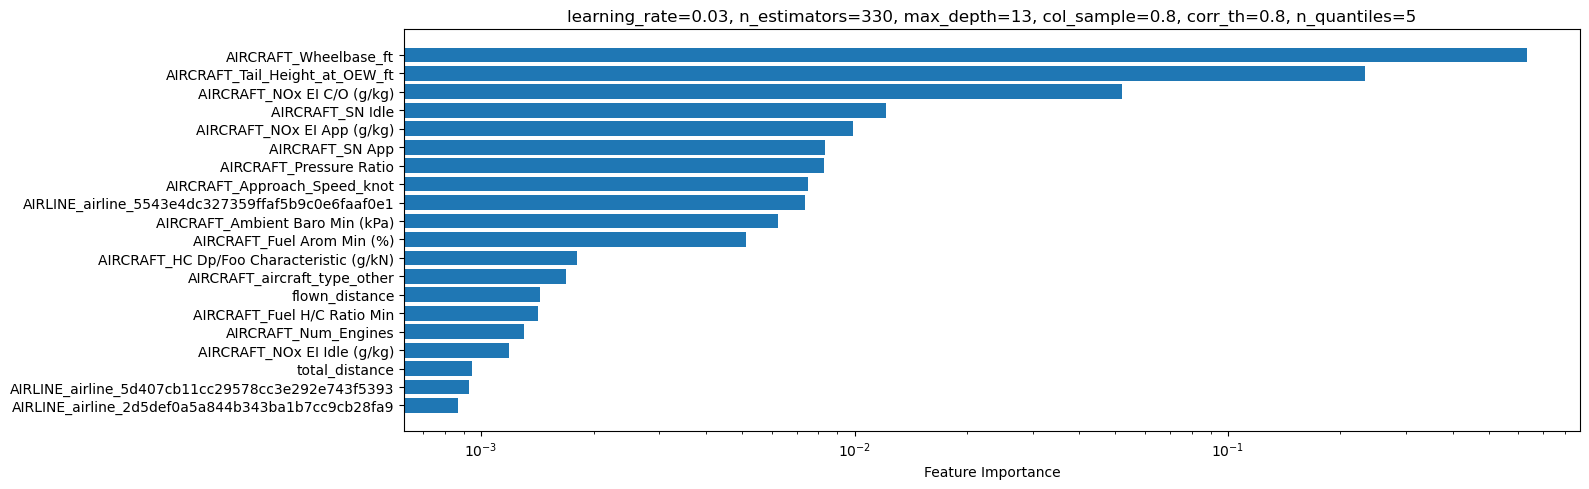

learning_rate=0.06, n_estimators=390, max_depth=4, col_sample=0.8, corr_th=0.95, n_quantiles=5: 0it [00:00, ?i…

Average RMSE: 3531.36
Standard Deviation: 22.15


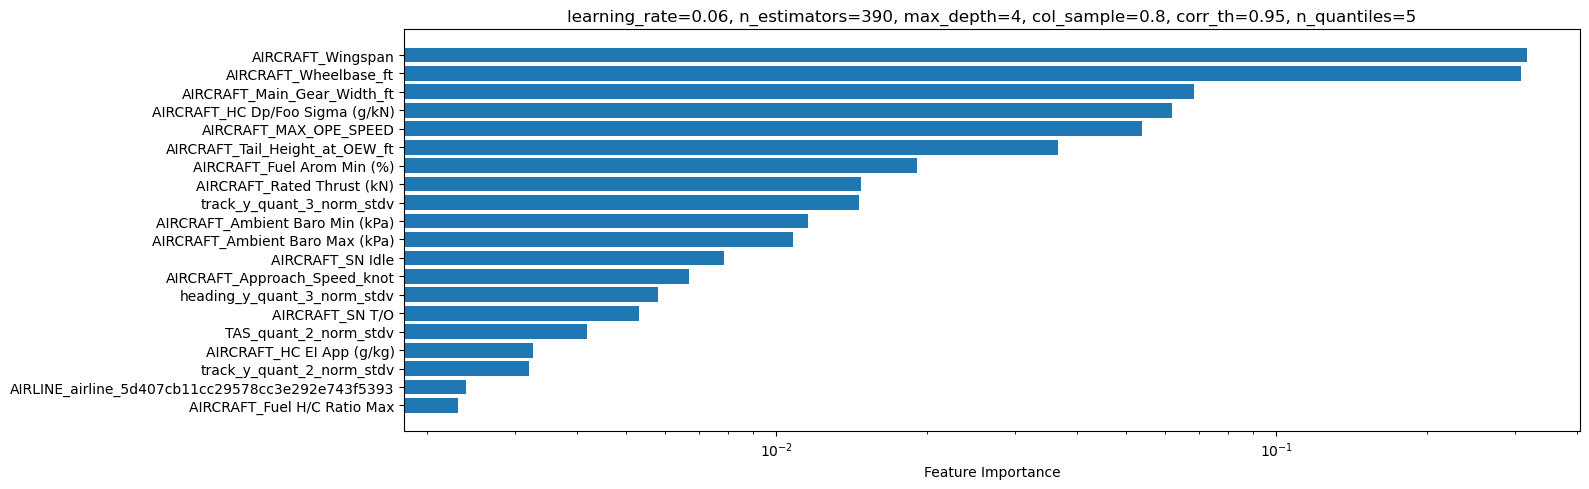

learning_rate=0.06, n_estimators=670, max_depth=3, col_sample=1.0, corr_th=0.75, n_quantiles=5: 0it [00:00, ?i…

Average RMSE: 3661.03
Standard Deviation: 15.68


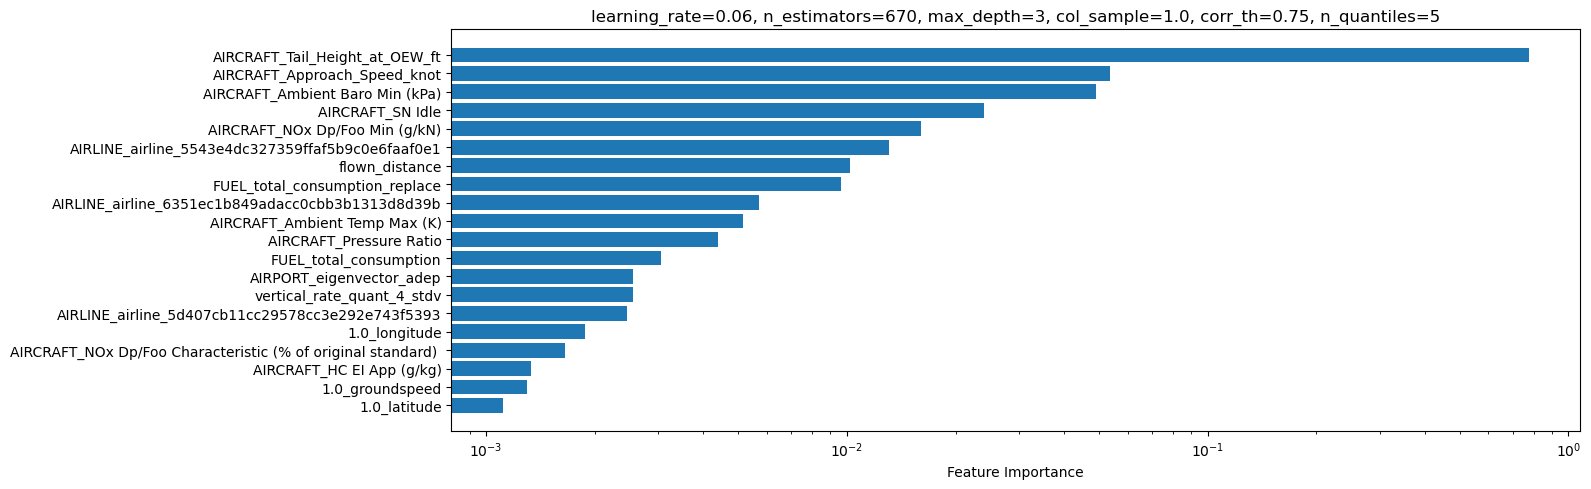

learning_rate=0.2, n_estimators=580, max_depth=14, col_sample=0.85, corr_th=0.9, n_quantiles=5: 0it [00:00, ?i…

Average RMSE: 3001.50
Standard Deviation: 12.09


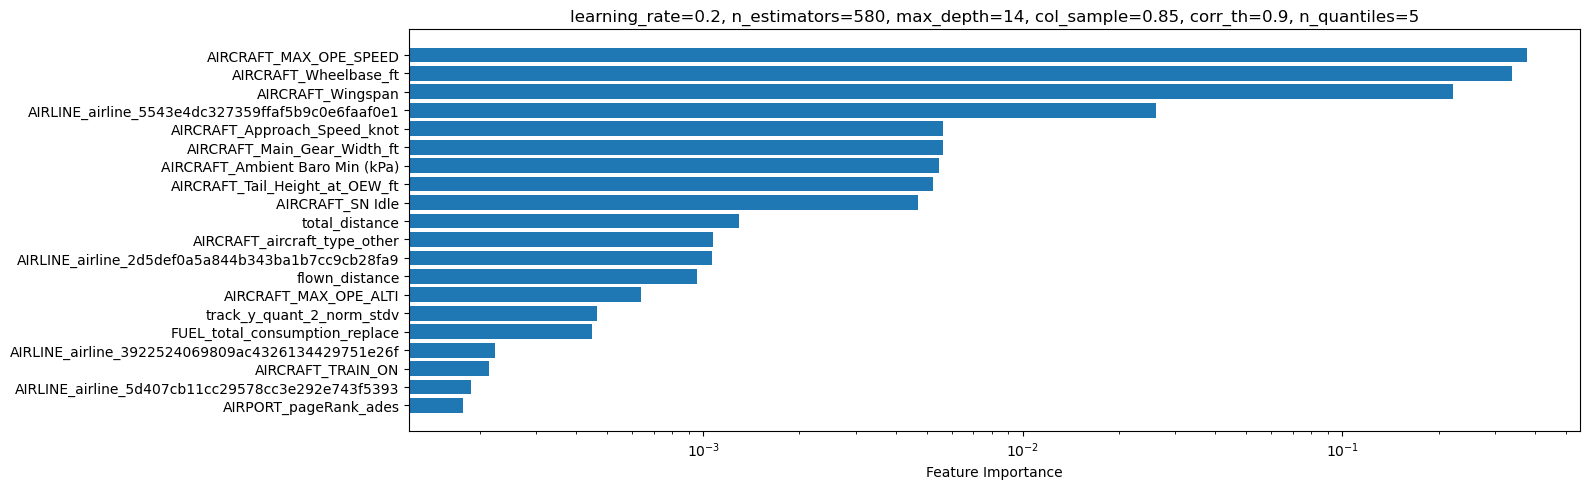

learning_rate=0.5, n_estimators=690, max_depth=12, col_sample=1.0, corr_th=0.8, n_quantiles=5: 0it [00:00, ?it…

Average RMSE: 3408.67
Standard Deviation: 27.92


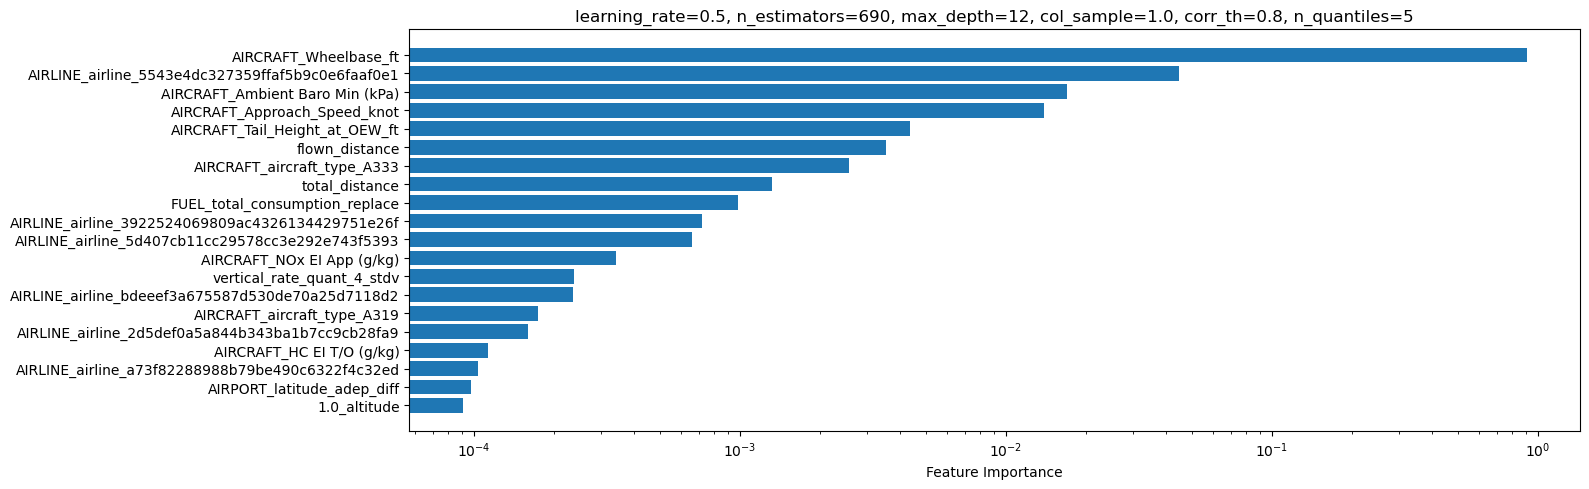

learning_rate=0.04, n_estimators=640, max_depth=17, col_sample=0.55, corr_th=0.95, n_quantiles=5: 0it [00:00, …

In [ ]:
top_n = 20 # number of most important features to store
n_folds = 5 # down from 20 cause aint nobody got time for that
model_random_seed = 42
hyperparam_random_seed = 42
train_test_random_seed = 42

# version = 1 is not called "v1", but simply ""
# version = 2 this includes fuel flow with (33%/13%) missing flights
# version = 3 adds explicit aircraft types on top of version 2
version = 4 # adds Bernard's engine per ac_type features on top of version 3
results_file_name = f"results_df_v{version}.pkl"

try:
    results_df = joblib.load(results_file_name)
except:
    results_df = pd.DataFrame(
        columns=[
            "learning_rate", "n_estimators", "max_depth", "col_sample", "corr_th", "n_quantiles", "RMSE_avg", "RMSE_std", "time_s"
        ] + np.array([[f"rank_{i+1}_feature", f"rank_{i+1}_importance"] for i in range(top_n)]).flatten().tolist()
    )
display(results_df.sort_values(by="RMSE_avg").head())

min_corr_th, max_corr_th = 0.8, .95   # .7, .95
min_max_depth, max_max_depth = 6, 12  # 3, 20
min_col_sample, max_col_sample = 0.8, 1 
min_n_estimators, max_n_estimators = 800, 1600 # 100, 2000
min_learning_rate, max_learning_rate = 1e-2, 1e-1 # 1e-2, 5e-1

possible_n_quantiles = [5]
possible_max_depths = np.arange(min_max_depth, max_max_depth+1, 1)
possible_corr_ths = np.arange(min_corr_th, max_corr_th+1e-3, .05).round(2)
possible_col_samples = np.arange(min_col_sample, max_col_sample+0.01, 0.05).round(2)
possible_n_estimators = np.arange(min_n_estimators//10, max_n_estimators//10+1, 1) * 10
possible_learning_rates = np.concatenate([
    np.arange(min_learning_rate*10**exp, min_learning_rate*10**(exp+1), min_learning_rate*10**exp)
    for exp in range(int(np.log10(1 / min_learning_rate)))
]).round(3)
possible_learning_rates = possible_learning_rates[possible_learning_rates<=max_learning_rate]

np.random.seed(hyperparam_random_seed)
for i in tqdm(range(200)):
    corr_th = np.random.choice(possible_corr_ths)
    max_depth = np.random.choice(possible_max_depths)
    col_sample = np.random.choice(possible_col_samples)
    n_quantiles = np.random.choice(possible_n_quantiles)
    n_estimators = np.random.choice(possible_n_estimators)
    learning_rate = np.random.choice(possible_learning_rates)
    
    desc = f"learning_rate={learning_rate}, n_estimators={n_estimators}, max_depth={max_depth}, " + \
           f"col_sample={col_sample}, corr_th={corr_th}, n_quantiles={n_quantiles}"
    
    hyperset = [learning_rate, n_estimators, max_depth, col_sample, corr_th, n_quantiles]
    result_done = ((results_df.values[:, :len(hyperset)]==hyperset).sum(axis=1)==len(hyperset)).sum()
    if not result_done:   
        X_y_df = joblib.load(f"X_y_df_cha_nq={n_quantiles}_v{version}.pkl")
        
        # id_columns = X_y_df.columns[:2]
        target_column = X_y_df.columns[-1]
        feature_columns = X_y_df.columns[2:-1]
        cat_features = [
            column for column in feature_columns if (
                ("airline_" in column) or ("aircraft_type_" in column)
            )
        ]
        num_features = sorted(list(set(feature_columns).difference(set(cat_features))))
        if f"X_y_cha_nq={n_quantiles}_corr_df_v{version}.pkl" not in os.listdir(os.getcwd()):
            corr_df = X_y_df[num_features].corr()
            joblib.dump(corr_df, f"X_y_cha_nq={n_quantiles}_corr_df_v{version}.pkl")
        else:
            corr_df = joblib.load(f"X_y_cha_nq={n_quantiles}_corr_df_v{version}.pkl")
        
        X = X_y_df[feature_columns]
        y = X_y_df[target_column]

        strata = np.array(range(len(X)), dtype=object)
        strata_columns = [column for column in cat_features if ("airline_" in column)]
        for strata_column in strata_columns:
            strata[X[strata_column].values.astype(bool)] = strata_column

        low_corr_columns = get_low_corr_columns(corr_df, corr_th).tolist() + cat_features

        rmses = []
        y_cuda = torch.from_numpy(y.values).to("cuda")
        X_cuda = torch.from_numpy(X[low_corr_columns].values).to("cuda")
        splitter = StratifiedKFold(n_splits=n_folds, random_state=train_test_random_seed, shuffle=True)
        for train_idx, test_idx in tqdm(splitter.split(strata, strata), leave=False, desc=desc):
            X_train, X_test = X_cuda[train_idx], X_cuda[test_idx]
            y_train, y_test = y_cuda[train_idx], y.values[test_idx]
            reg = XGBR(
                n_jobs=-1,
                device="cuda",
                max_depth=max_depth, 
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                colsample_bytree=col_sample,
                colsample_bylevel=col_sample,
                colsample_bynode=col_sample,
                random_state=model_random_seed,
            ).fit(X_train, y_train)
            y_pred = reg.predict(X_test)
            rmses.append(rmse(y_test, y_pred))

        mean_rmse = np.mean(rmses)
        stdv_rmse = np.std(rmses, ddof=0)
        if not len(results_df):
            results_df = pd.DataFrame(
                data=[
                    hyperset + [mean_rmse, stdv_rmse] + np.repeat(np.nan, len(results_df.columns) - len(hyperset) - 2).tolist()
                ],
                columns=results_df.columns
            )
            str_cols = [column for column in results_df.columns if "feature" in column]
            results_df[str_cols] = results_df[str_cols].astype(str)
        
        else:
            row_df = pd.DataFrame(
                data=[
                    hyperset + [mean_rmse, stdv_rmse] + np.repeat(np.nan, len(results_df.columns) - len(hyperset) - 2).tolist()
                ],
                columns=results_df.columns
            )
            str_cols = [column for column in row_df.columns if "feature" in column]
            row_df[str_cols] = row_df[str_cols].astype(str)
            
            results_df = pd.concat(
                [results_df, row_df],
                ignore_index=True,
                axis=0,
            )

        start = time.time()
        reg = XGBR(
            n_jobs=-1,
            device="cuda",
            max_depth=max_depth, 
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            colsample_bytree=col_sample,
            colsample_bylevel=col_sample,
            colsample_bynode=col_sample,
            random_state=model_random_seed,
        ).fit(X_cuda, y_cuda)
        stop = time.time()
        results_df.loc[
            (results_df.values[:, :len(hyperset)]==hyperset).sum(axis=1)==len(hyperset),
            "time_s"
        ] = stop - start
        
        feature_order_idxs = np.argsort(reg.feature_importances_)[::-1]
        for i in range(top_n):
            feature_name = (X[low_corr_columns].columns[feature_order_idxs])[i]
            feature_importance = (reg.feature_importances_[feature_order_idxs])[i]
        
            results_df.loc[
                (results_df.values[:, :len(hyperset)]==hyperset).sum(axis=1)==len(hyperset),
                f"rank_{i+1}_feature"
            ] = feature_name
        
            results_df.loc[
                (results_df.values[:, :len(hyperset)]==hyperset).sum(axis=1)==len(hyperset),
                 f"rank_{i+1}_importance"
            ] = feature_importance
        joblib.dump(results_df, results_file_name)
        
    mean_rmse, stdv_rmse = results_df.loc[
        (results_df.values[:, :len(hyperset)]==hyperset).sum(axis=1)==len(hyperset),
        ["RMSE_avg", "RMSE_std"]
    ].values.flatten()
    
    features = results_df.loc[
        (results_df.values[:, :len(hyperset)]==hyperset).sum(axis=1)==len(hyperset),
        [column for column in results_df.columns if "feature" in column]
    ].values.flatten()
    
    importances = results_df.loc[
        (results_df.values[:, :len(hyperset)]==hyperset).sum(axis=1)==len(hyperset),
        [column for column in results_df.columns if "importance" in column]
    ].values.flatten()
    
    print(
        f"Average RMSE: {mean_rmse:.2f}"+\
        f"\nStandard Deviation: {stdv_rmse:.2f}"
    )
    
    fig, ax = plt.subplots(1,1, dpi=100, figsize=(16,5))
    plt.clf()
    plt.barh(
        y=features[::-1],
        width=importances[::-1]
    )
    plt.title(desc)
    plt.xlabel("Feature Importance")
    plt.xscale("log")
    plt.tight_layout()
    plt.show()
    print("\n\n")   